# Pre-processing of GLAMOS MB data:

Does the pre-processing of the point MB measurements from GLAMOS (winter and summer).

# Point Mass Balance data:

## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from cmcrameri import cm
from calendar import monthrange

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_CH import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

## Transform .dat files to .csv:

Transform the seasonal and winter PMB .dat files to .csv for simplicity. 

In [3]:
# # Get all files with pmb (for winter and annual mb):
# glamosfiles_mb_a, glamosfiles_mb_w = [], []
# for file in os.listdir(path_PMB_GLAMOS_a_raw):
#     # check if current path is a file
#     if os.path.isfile(os.path.join(path_PMB_GLAMOS_a_raw, file)):
#         glamosfiles_mb_a.append(file)

# for file in os.listdir(path_PMB_GLAMOS_w_raw):
#     # check if current path is a file
#     if os.path.isfile(os.path.join(path_PMB_GLAMOS_w_raw, file)):
#         glamosfiles_mb_w.append(file)

# print('Examples of index stake raw files:\n', glamosfiles_mb_a[:5])

# # Transform all files to csv
# emptyfolder(path_PMB_GLAMOS_csv_a)
# emptyfolder(path_PMB_GLAMOS_csv_w)
# for file in glamosfiles_mb_a:
#     fileName = re.split('.dat', file)[0]
#     processDatFile(fileName, path_PMB_GLAMOS_a_raw, path_PMB_GLAMOS_csv_a)

# for file in glamosfiles_mb_w:
#     fileName = re.split('.dat', file)[0]
#     processDatFile(fileName, path_PMB_GLAMOS_w_raw, path_PMB_GLAMOS_csv_w)

# # Separate clariden into clariden II and III
# fileName = 'clariden_annual.csv'
# clariden_csv_a = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
#                                 sep=',',
#                                 header=0,
#                                 encoding='latin-1')
# clariden_csv_a[clariden_csv_a['# name'] == 'L'].to_csv(
#     path_PMB_GLAMOS_csv_a + 'claridenL_annual.csv', index=False)
# clariden_csv_a[clariden_csv_a['# name'] == 'U'].to_csv(
#     path_PMB_GLAMOS_csv_a + 'claridenU_annual.csv', index=False)

# fileName = 'clariden_winter.csv'
# clariden_csv_w = pd.read_csv(path_PMB_GLAMOS_csv_w + fileName,
#                                 sep=',',
#                                 header=0,
#                                 encoding='latin-1')
# clariden_csv_w[clariden_csv_w['# name'] == 'L'].to_csv(
#     path_PMB_GLAMOS_csv_w + 'claridenL_winter.csv', index=False)
# clariden_csv_w[clariden_csv_w['# name'] == 'U'].to_csv(
#     path_PMB_GLAMOS_csv_w + 'claridenU_winter.csv', index=False)

# os.remove(path_PMB_GLAMOS_csv_a + 'clariden_annual.csv')
# os.remove(path_PMB_GLAMOS_csv_w + 'clariden_winter.csv')

# # Example:
# fileName = 'aletsch_annual.csv'
# aletsch_csv = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
#                           sep=',',
#                           header=0,
#                           encoding='latin-1')
# aletsch_csv.head(2)

process_pmb_dat_files()

##  Assemble measurement periods:
### Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [4]:
# # List to collect processed DataFrames
# df_list = []

# # Process files
# for file in tqdm(os.listdir(path_PMB_GLAMOS_csv_a), desc='Annual stakes'):
#     fileName = re.split('.csv', file)[0]
#     glacierName = re.split('_', fileName)[0]

#     # Read CSV
#     df = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_a, file),
#                      sep=',',
#                      header=0,
#                      encoding='latin-1')
#     df['glacier'] = glacierName
#     df['period'] = 'annual'

#     # Transform dates
#     df = transformDates(df)

#     # Drop duplicates early
#     df = df.drop_duplicates()

#     # Transform coordinates (from LV03 to WGS84)
#     df = LV03toWGS84(df)

#     # Append processed DataFrame to the list
#     df_list.append(df)

# # Concatenate all processed DataFrames
# df_annual_raw = pd.concat(df_list, ignore_index=True)

# # Process YEAR column and filter by year
# df_annual_raw['YEAR'] = pd.to_datetime(df_annual_raw['date1']).dt.year
# df_annual_raw = df_annual_raw[df_annual_raw['YEAR'] >= 1950]

# # Rename and reorder columns for WGMS format
# columns_mapping = {
#     '# name': 'POINT_ID',
#     'lat': 'POINT_LAT',
#     'lon': 'POINT_LON',
#     'height': 'POINT_ELEVATION',
#     'date0': 'FROM_DATE',
#     'date1': 'TO_DATE',
#     'mb_we': 'POINT_BALANCE',
#     'glacier': 'GLACIER',
#     'period': 'PERIOD'
# }
# df_annual_raw.rename(columns=columns_mapping, inplace=True)

# columns_order = [
#     'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
#     'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'date_fix0',
#     'date_fix1', 'time0', 'time1', 'date_quality', 'position_quality',
#     'mb_raw', 'density', 'density_quality', 'measurement_quality',
#     'measurement_type', 'mb_error', 'reading_error', 'density_error',
#     'error_evaluation_method', 'source'
# ]
# df_annual_raw = df_annual_raw[columns_order]

# # Remove rows with invalid year difference
# valid_date_mask = (
#     pd.to_datetime(df_annual_raw['TO_DATE'], format='%Y%m%d').dt.year -
#     pd.to_datetime(df_annual_raw['FROM_DATE'], format='%Y%m%d').dt.year) == 1
# df_annual_raw = df_annual_raw[valid_date_mask]

# # Filter measurement type and quality
# df_annual_raw = df_annual_raw[(df_annual_raw['measurement_type'] <= 2)
#                               & (df_annual_raw['measurement_quality'] == 1)]

# # Remove duplicates as a final step
# df_annual_raw = df_annual_raw.drop_duplicates()

# Display the first two rows
df_annual_raw = process_annual_stake_data(path_PMB_GLAMOS_csv_a)
df_annual_raw.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,mb_raw,density,density_quality,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,2003,01,oberaar,20021006,20031011,46.538806,8.233237,2389.812633,-6174,annual,...,-686,900,1,1,1,102,45,92,0,hm
1,2003,02,oberaar,20021006,20031011,46.536611,8.225514,2499.825727,-5310,annual,...,-590,900,1,1,1,91,45,79,0,hm


### Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

In [5]:
# # Clear the output folder
# emptyfolder(path_PMB_GLAMOS_csv_w_clean)

# # Pre-filter glaciers with winter measurements
# winter_glaciers = {
#     re.split('_winter.csv', f)[0]
#     for f in os.listdir(path_PMB_GLAMOS_csv_w)
# }
# annual_glaciers = set(df_annual_raw.GLACIER.unique())
# glaciers_to_process = annual_glaciers.intersection(winter_glaciers)

# # Process each glacier
# for glacier in tqdm(glaciers_to_process,
#                     desc='Processing Winter Glaciers',
#                     leave=False):
#     # Read winter measurements
#     df_winter = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_w,
#                                          f"{glacier}_winter.csv"),
#                             sep=',',
#                             header=0,
#                             encoding='latin-1')
#     df_winter['period'] = 'winter'
#     df_winter['glacier'] = glacier

#     # Transform dates and remove duplicates
#     df_winter = transformDates(df_winter).drop_duplicates()

#     # Convert coordinates to lat/lon
#     df_winter = LV03toWGS84(df_winter)

#     # Add YEAR column and filter to >= 1950
#     df_winter['YEAR'] = pd.to_datetime(df_winter['date1']).dt.year
#     df_winter = df_winter[df_winter['YEAR'] >= 1950]

#     # Rename and reorder columns
#     columns_mapping = {
#         '# name': 'POINT_ID',
#         'lat': 'POINT_LAT',
#         'lon': 'POINT_LON',
#         'height': 'POINT_ELEVATION',
#         'date0': 'FROM_DATE',
#         'date1': 'TO_DATE',
#         'mb_we': 'POINT_BALANCE',
#         'glacier': 'GLACIER',
#         'period': 'PERIOD'
#     }
#     columns_order = [
#         'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
#         'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'date_fix0',
#         'date_fix1', 'time0', 'time1', 'date_quality', 'position_quality',
#         'mb_raw', 'density', 'density_quality', 'measurement_quality',
#         'measurement_type', 'mb_error', 'reading_error', 'density_error',
#         'error_evaluation_method', 'source'
#     ]
#     df_winter.rename(columns=columns_mapping, inplace=True)
#     df_winter = df_winter[columns_order]

#     # Filter measurements by type and quality
#     df_winter = df_winter[(df_winter['measurement_type'] <= 2)
#                           & (df_winter['measurement_quality'] == 1)]

#     # Save the processed DataFrame to a CSV file
#     output_file = os.path.join(path_PMB_GLAMOS_csv_w_clean,
#                                f"{glacier}_winter_all.csv")
#     df_winter.to_csv(output_file, index=False)

process_winter_stake_data(df_annual_raw, path_PMB_GLAMOS_csv_w,
                          path_PMB_GLAMOS_csv_w_clean)

### Assemble both periods:

In [6]:
# # # Copy annual data
# # df_all_raw = df_annual_raw.copy()

# # # Collect all winter stake files
# # files_stakes = [
# #     f for f in os.listdir(path_PMB_GLAMOS_csv_w_clean) if '_winter_all' in f
# # ]

# # # Combine winter stake data
# # winter_dataframes = []
# # for file in files_stakes:
# #     glacier_name = re.split('_', re.split('.csv', file)[0])[0]
# #     df_winter = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_w_clean, file),
# #                             sep=',',
# #                             header=0,
# #                             encoding='latin-1').drop(columns='Unnamed: 0',
# #                                                      errors='ignore')
# #     winter_dataframes.append(df_winter)

# # # Concatenate all winter dataframes with annual data
# # if winter_dataframes:
# #     df_all_raw = pd.concat([df_all_raw] + winter_dataframes, ignore_index=True)

# # # Reset index
# # df_all_raw.reset_index(drop=True, inplace=True)

# # # Correct winter date issues
# # df_all_raw = CleanWinterDates(df_all_raw)

# # Assemble both annual and winter measurements:
# # Collect all winter stake files
# files_stakes = [
#     f for f in os.listdir(path_PMB_GLAMOS_csv_w_clean) if '_winter_all' in f
# ]

# # Combine winter stake data
# winter_dataframes = []
# for file in files_stakes:
#     glacier_name = re.split('_', re.split('.csv', file)[0])[0]
#     df_winter = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_w_clean, file),
#                             sep=',',
#                             header=0,
#                             encoding='latin-1').drop(columns='Unnamed: 0',
#                                                      errors='ignore')
#     winter_dataframes.append(df_winter)

# df_all_raw = pd.concat([df_annual_raw] + winter_dataframes, ignore_index=True)

# # Reset index
# df_all_raw.reset_index(drop=True, inplace=True)

# # Correct winter date issues
# df_all_raw = CleanWinterDates(df_all_raw)

# # Display data stats
# print('Number of winter and annual samples:', len(df_all_raw))
# print('Number of winter samples:',
#       len(df_all_raw[df_all_raw.PERIOD == 'winter']))
# print('Number of annual samples:',
#       len(df_all_raw[df_all_raw.PERIOD == 'annual']))

# # Remove Pers glacier as it's part of the Morteratsch ensemble
# df_all_raw = df_all_raw[df_all_raw.GLACIER != 'pers']

# # Save all data to CSV
# df_all_raw.to_csv(os.path.join(path_PMB_GLAMOS_csv, 'df_all_raw.csv'),
#                   index=False)

# # Save coordinates for all stakes
# df_all_raw[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
#             'PERIOD']].to_csv('coordinates_all.csv', index=False)

df_all_raw = assemble_all_stake_data(df_annual_raw, path_PMB_GLAMOS_csv_w_clean, path_PMB_GLAMOS_csv)

Number of winter and annual samples: 37618
Number of winter samples: 28202
Number of annual samples: 9416


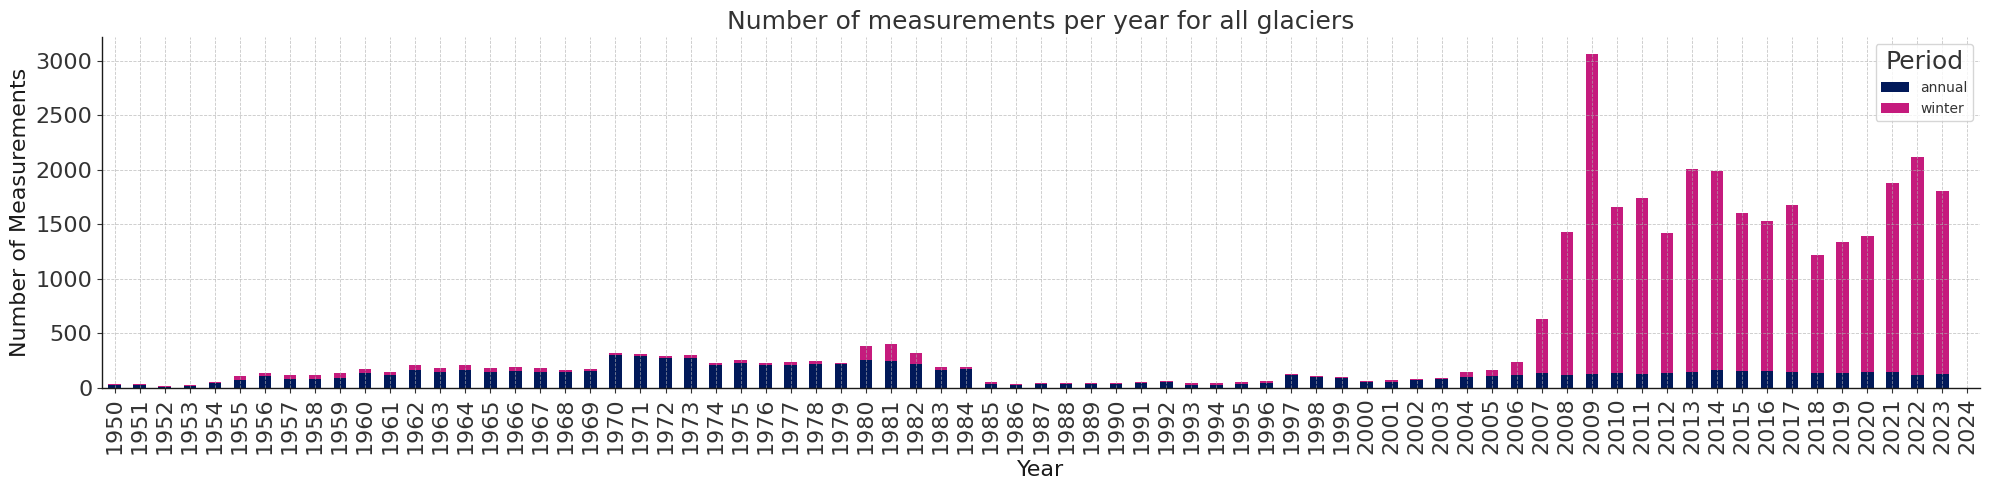

In [8]:
# Plot: Number of measurements per year
df_measurements_per_year = df_all_raw.groupby(['YEAR',
                                               'PERIOD']).size().unstack()
df_measurements_per_year.plot(kind='bar',
                              stacked=True,
                              figsize=(20, 5),
                              color=[color_1, color_2])
plt.title('Number of measurements per year for all glaciers')
plt.ylabel('Number of Measurements')
plt.xlabel('Year')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

## Add RGIs Ids:

For each PMB measurement, we want to add the RGI ID (v6) of the shapefile it belongs to. 

In [ ]:
# take all winter and annual stakes (lots of snow probes)
df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1')

# Keep relevant WGMS columns:
df_pmb = df_all_raw[[
    'YEAR',
    'POINT_ID',
    'GLACIER',
    'FROM_DATE',
    'TO_DATE',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_BALANCE',
    'PERIOD',
]]

# Add RGIs:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'

# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# Add RGI IDs through intersection
df_pmb = mbm.data_processing.utils.get_rgi(data=df_pmb,
                                           glacier_outlines=glacier_outline)

# Handle unmatched points
no_match_df = df_pmb[df_pmb['RGIId'].isna()]
geometry = [
    Point(lon, lat)
    for lon, lat in zip(no_match_df["POINT_LON"], no_match_df["POINT_LAT"])
]
points_gdf = gpd.GeoDataFrame(no_match_df,
                              geometry=geometry,
                              crs=glacier_outline.crs)

for index in tqdm(no_match_df.index):
    point = points_gdf.loc[index]['geometry']
    polygon_index = glacier_outline.distance(point).sort_values().index[0]
    closest_rgi = glacier_outline.loc[polygon_index].RGIId
    df_pmb.at[index, 'RGIId'] = closest_rgi

In [ ]:
# Preprocess data
rgiids6 = df_pmb[['GLACIER', 'RGIId']].drop_duplicates()
print("RGIs before pre-processing:")
check_multiple_rgi_ids(rgiids6)

# Clean the data
df_pmb_clean = clean_rgi_ids(df_pmb.copy())
df_pmb_clean.reset_index(drop=True, inplace=True)

# Verify post-processing
rgiids6_clean = df_pmb_clean[['GLACIER', 'RGIId']].drop_duplicates()
print("RGIs after pre-processing:")
check_multiple_rgi_ids(rgiids6_clean)

## Cut from 1951:

In [ ]:
# Filter to start of MS data (1951) or ERA5-Land data (1950):
df_pmb_50s = df_pmb_clean[df_pmb_clean.YEAR > 1950].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])

# Change from mm w.e. to m w.e.
df_pmb_50s['POINT_BALANCE'] = df_pmb_50s['POINT_BALANCE'] / 1000

# merge ClaridenL and ClaridenU into one glacier:
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenU', 'GLACIER'] = 'clariden'
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenL', 'GLACIER'] = 'clariden'

print('Number of winter and annual samples:', len(df_pmb_50s))
print('Number of annual samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'winter']))

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s.groupby(['YEAR',
                    'PERIOD']).size().unstack().plot(kind='bar',
                                                     stacked=True,
                                                     color=[color_1, color_2],
                                                     ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

### Merge stakes that are close: 
Especially with winter probes, a lot of measurements were done at the same place in the raw data and this leads to noise. We merge the stakes that are very close and keep the mean of the measurement.


In [ ]:
# clean df_pmb_50s
# Group similar stakes:
df_pmb_50s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_50s.GLACIER.unique(), desc='glacier', position=0):
    print('----------------\n', gl, ':\n----------------')
    df_gl = df_pmb_50s[df_pmb_50s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_50s_clean = pd.concat([df_pmb_50s_clean, df_gl_cleaned])

# save to csv:
df_pmb_50s_clean.drop(['x', 'y'],
                      axis=1).to_csv(path_PMB_GLAMOS_csv + f'df_pmb_all.csv',
                                     index=False)

# save coordinates:
df_pmb_50s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
                  'PERIOD']].to_csv(path_PMB_GLAMOS_csv +
                                    f'coordinate_50s_clean_all.csv')

In [ ]:
# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s_clean.groupby(['YEAR', 'PERIOD'
                          ]).size().unstack().plot(kind='bar',
                                                   stacked=True,
                                                   color=[color_1, color_2],
                                                   ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s_clean.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

In [ ]:
glacier_list = list(df_pmb_50s_clean.GLACIER.unique())
print('Number of glaciers:', len(glacier_list))
glacier_list.sort()
glacier_list

In [ ]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_50s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

num_gl_annual = df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual'].groupby(
    ['GLACIER']).size().sort_values()

# Plot one glacier per column:
big_gl = num_gl_annual[num_gl_annual > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title

In [ ]:
print('Number of winter and annual samples:', len(df_pmb_50s_clean))
print('Number of annual samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'winter']))

## Add topographical information from OGGM:

In [ ]:
# Load the dataset
file_path = os.path.join(path_PMB_GLAMOS_csv, 'CH_wgms_dataset_all.csv')
df_pmb_topo = pd.read_csv(file_path)

# Remove 'pers' glacier
df_pmb_topo = df_pmb_topo.loc[df_pmb_topo.GLACIER != 'pers']

# Count and display the number of samples
print(f"Total number of winter and annual samples: {len(df_pmb_topo)}")

# Count occurrences of 'PERIOD' values
period_counts = df_pmb_topo['PERIOD'].value_counts()
print(f"Number of annual samples: {period_counts.get('annual', 0)}")
print(f"Number of winter samples: {period_counts.get('winter', 0)}")

# Unique years, sorted
unique_years = np.sort(df_pmb_topo.YEAR.unique())
print(f"Unique years: {unique_years}")

# Unique glaciers, sorted
glacier_list = sorted(df_pmb_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

## Give new stake IDs:
Give new stake IDs with glacier name and then a number according to the elevation. This is because accross glaciers some stakes have the same ID which is not practical.

In [ ]:
for glacierName in tqdm(df_pmb_topo.GLACIER.unique(), desc='glaciers'):
    gl_data = df_pmb_topo[df_pmb_topo.GLACIER == glacierName]
    stakeIDS = gl_data.groupby('POINT_ID')[[
        'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION'
    ]].mean()
    stakeIDS.reset_index(inplace=True)
    # Change the ID according to elevation
    new_ids = stakeIDS[['POINT_ID',
                        'POINT_ELEVATION']].sort_values(by='POINT_ELEVATION')
    new_ids['POINT_ID_new'] = [
        f'{glacierName}_{i}' for i in range(len(new_ids))
    ]
    for i, row in new_ids.iterrows():
        df_pmb_topo.loc[(df_pmb_topo.GLACIER == glacierName) &
                        (df_pmb_topo.POINT_ID == row.POINT_ID),
                        'POINT_ID'] = row.POINT_ID_new

# Check the condition
check_point_ids_contain_glacier(df_pmb_topo)
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))

# Save to csv:
df_pmb_topo.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
                   index=False)

# Histogram of mass balance
df_pmb_topo['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')

# Glacier wide MB:

## Obs: no fixed dates, but using observed periods.

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'obs' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])

# Transform all files to csv
emptyfolder(path_SMB_GLAMOS_csv + 'obs/')
for file in glamosfiles_smb:
    fileName = re.split('.dat', file)[0]
    processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                        path_SMB_GLAMOS_csv + 'obs/')

# Example:
fileName = 'aletsch_obs.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'obs/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

## Fix: with fixed periods (hydrological year).

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'fix' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])
# Transform all files to csv
emptyfolder(path_SMB_GLAMOS_csv + 'fix/')
for file in glamosfiles_smb:
    fileName = re.split('.dat', file)[0]
    processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                        path_SMB_GLAMOS_csv + 'fix/')

# Example:
fileName = 'aletsch_fix.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

# Potential incoming clear sky solar radiation:

Pre-process glamos data of Potential incoming clear sky solar radiation (pcsr) used as a topographical variable. One per day grid per glacier for one year only, depends on the glacier.

In [ ]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

glDirect = np.sort(os.listdir(path_pcsr + 'raw/'))  # Glaciers with data

print('Number of glacier with clear sky radiation data:', len(glDirect))
print('Glaciers with clear sky radiation data:', glDirect)

In [ ]:
path_pcsr_save = path_pcsr + 'csv/'
empty = False
if empty:
    emptyfolder(path_pcsr_save)
else:
    glProcessed = [
        re.search(r"xr_direct_(.*)\.nc", f).group(1)
        for f in os.listdir(path_pcsr_save)
    ]
    glDirect = list(set(glDirect) - set(glProcessed))

for glacierName in tqdm(glDirect, desc='glaciers', position=0):
    print(glacierName)
    grid = os.listdir(path_pcsr + 'raw/' + glacierName)
    grid_year = int(re.findall(r'\d+', grid[0])[0])
    daily_grids = os.listdir(path_pcsr + 'raw/' + glacierName + '/' + grid[0])
    # Sort by day number from 001 to 365
    daily_grids.sort()
    grids = []
    for fileName in daily_grids:
        if 'grid' not in fileName:
            continue

        # Load daily grid file
        file_path = path_pcsr + 'raw/' + glacierName + '/' + grid[
            0] + '/' + fileName
        metadata, grid_data = load_grid_file(file_path)
        grids.append(grid_data)

    # Take monthly means:
    monthly_grids = []
    for i in range(12):
        num_days_month = monthrange(grid_year, i + 1)[1]
        monthly_grids.append(
            np.mean(np.stack(grids[i * num_days_month:(i + 1) *
                                   num_days_month],
                             axis=0),
                    axis=0))

    monthly_grids = np.array(monthly_grids)
    num_months = monthly_grids.shape[0]

    # Convert to xarray (CH coordinates)
    data_array = convert_to_xarray(monthly_grids, metadata, num_months)

    # Convert to WGS84 (lat/lon) coordinates
    data_array_transf = transform_xarray_coords_lv03_to_wgs84(data_array)

    # Save xarray
    if glacierName == 'findelen':
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_adler.nc')
    elif glacierName == 'stanna':
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_sanktanna.nc')
    else:
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')

In [ ]:
# Number of processed glaciers:
print('Number of processed glaciers:', len(os.listdir(path_pcsr_save)))

# read an plot one file
xr_file = xr.open_dataset(path_pcsr_save + 'xr_direct_clariden.nc')
xr_file['grid_data'].plot(x='x', y='y', col='time', col_wrap=3)